### **Transfer learning - feature extraction**

* It is leveraging a working model's existing architecture and learned patterns for our own problem
* There are two main benefits
  * Can leverage an existing NN-architecture proven to work on problems similar to our own
  * Can leverage a working NN-architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [11]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibilitypip install --upgrade tensorflow-hub
random_seed=42
tf.random.set_seed(random_seed)

**Data:**
* 10% of 10 food classes from Food 101 dataset

In [5]:
import os

for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 10 directori

In [6]:
# setup paths to data directory
train_dir='10_food_classes_10_percent/train'
test_dir='10_food_classes_10_percent/test'

# getting the sub-dirs to get classnames
import pathlib
datadir = pathlib.Path(train_dir)
class_names=np.array(sorted([item.name for item in datadir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [7]:
# Pre-process the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE=32

# initializing ImageDataGenerator with augmentation
train_datagen_augmented=ImageDataGenerator(rescale = 1/255.0,
                                 rotation_range = 90, # amount of rotation (degrees)
                                 shear_range = 0.2, # amount of shear range
                                 zoom_range = 0.2, # amount of zoom
                                 width_shift_range = 0.2, # move image along x-axis
                                 height_shift_range = 0.3, # move image along y-axis
                                 horizontal_flip = True # flips image horizontally
                                 )
valid_datagen=ImageDataGenerator(rescale=1/255.0,)

train_data=train_datagen_augmented.flow_from_directory(directory=train_dir,
                                             batch_size=BATCH_SIZE, # mini batch size
                                             target_size=IMAGE_SHAPE, # target size of images (h,w) 
                                             class_mode="categorical", # 'categorical' (default), 'binary',..
                                             seed = random_seed,
                                             shuffle=True 
                                             )

valid_data=valid_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SHAPE,
                                             class_mode="categorical",
                                             seed = random_seed,
                                             shuffle=True 
                                             )


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


**1. Setting up callbacks**

* Things to run whilst our model trains. 
* These are extra functionality you can add to your models to be performed during or after training
* Some most popular callbacks
  * Tracking experiment with Tensorboard callback
  * Model checkpointing with the ModelCheckpoint callback 
  * Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback
  * LearningRateSchedular

In [37]:
# create tensorboard callback (functionalized because we need to create a new one for each model)
import datetime as dt
import tf_keras
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf_keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to : {log_dir}")
    return tensorboard_callback

**2. Creating models using Tensorflow Hub**

* We can access predefined models from https://tfhub.dev/
* Browsing the Tensorflow and sorting for image classification, we found the following feature vector model link: 
  * EfficientNet b0: https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1
  * Resnet V2 -50: https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-feature-vector/2

**3. Building and Compiling Tensorflow feature extraction model**

In [9]:
resnet_url="https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-feature-vector/2"
efficientnet_url="https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [13]:
# import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# brilliant way to add an element to tuple
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [26]:
# define a create model function using a url
import tf_keras

def create_model(model_url,num_classes):
    '''
    Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A tensorflow hub feature extraction URL.
        num_classes (int): number of output neurons in output layer
    
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output  layer with num_classes output neurons.
    '''

    # download the pre-trained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,# freeze already learnt patterns(ImageNet)
                                             name='feature_extraction_layer',
                                             input_shape = IMAGE_SHAPE+(3,)
                                            )
    
    # create sequential model
    model=tf_keras.models.Sequential()
    model.add(feature_extractor_layer)
    model.add(tf_keras.layers.Dense(units=num_classes,name='output_layer',activation='softmax'))

    return model

In [16]:
train_data.num_classes

10

**4. Resnet-50 v2 vs Efficient net b0**

In [28]:
# create RESNET V2 - 50
resnet_model=create_model(model_url=resnet_url,num_classes=train_data.num_classes)
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              42626560  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 42647050 (162.69 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 42626560 (162.61 MB)
_________________________________________________________________


In [31]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf_keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [38]:
# fitting model 
resnet_history  = resnet_model.fit(train_data,
                                   epochs=5,
                                   steps_per_epoch=len(train_data),
                                   validation_data=valid_data,
                                   validation_steps=len(valid_data),
                                   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="resnet50v2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50v2/20250312-001548
Epoch 1/5


2025-03-12 00:15:53.338670: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-03-12 00:15:53.429453: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-03-12 00:15:53.485237: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-03-12 00:15:53.541812: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-03-12 00:15:53.617137: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


24/24 [==============================] - 206s 9s/step - loss: 2.1960 - accuracy: 0.2773 - val_loss: 1.3294 - val_accuracy: 0.5724
Epoch 2/5
24/24 [==============================] - 188s 8s/step - loss: 1.2387 - accuracy: 0.6040 - val_loss: 0.9180 - val_accuracy: 0.6972
Epoch 3/5
24/24 [==============================] - 187s 8s/step - loss: 0.9839 - accuracy: 0.6720 - val_loss: 0.7923 - val_accuracy: 0.7440
Epoch 4/5
24/24 [==============================] - 187s 8s/step - loss: 0.8443 - accuracy: 0.7187 - val_loss: 0.7571 - val_accuracy: 0.7568
Epoch 5/5
24/24 [==============================] - 186s 8s/step - loss: 0.7885 - accuracy: 0.7293 - val_loss: 0.7081 - val_accuracy: 0.7760


In [39]:
# plotting validation and training curves separately

def plot_loss_curves(history):
    # loss
    loss=history.history["loss"]
    val_loss=history.history['val_loss']

    # accuracy
    accuracy=tf.multiply(history.history['accuracy'],100)
    val_accuracy=tf.multiply(history.history['val_accuracy'],100)
    
    min_loss=tf.reduce_min(loss)
    min_val_loss=tf.reduce_min(val_loss)
    loc_loss=tf.argmin(loss)+1
    loc_val_loss=tf.argmin(val_loss)+1

    max_accuracy=tf.reduce_max(accuracy)
    max_val_accuracy=tf.reduce_max(val_accuracy)
    loc_acc=tf.argmax(accuracy)+1
    loc_val_acc=tf.argmax(val_accuracy)+1

    epochs = range(1,len(history.history["loss"])+1) # length of one of history object


    # plotting
    plt.figure()
    fig,axs=plt.subplots(1,2,figsize=(8,3))
    
    # loss
    axs[0].plot(epochs,loss,label=f'training loss (min:{min_loss:.2f})')
    axs[0].scatter(loc_loss,min_loss,s=30,color=(1,0,0))
    axs[0].plot(epochs,val_loss,label=f'validation loss (min:{min_val_loss:.2f})')
    axs[0].scatter(loc_val_loss,min_val_loss,s=30,color=(1,0,0))
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training & Validation')
    axs[0].legend()

    # accuracy
    axs[1].plot(epochs,accuracy,label=f'training accuracy (max:{max_accuracy:.2f}%)')
    axs[1].scatter(loc_acc,max_accuracy,s=30,color=(0,1,0))
    axs[1].plot(epochs,val_accuracy,label=f'validation accuracy (max:{max_val_accuracy:.2f}%)')
    axs[1].scatter(loc_val_acc,max_val_accuracy,s=30,color=(0,1,0))
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss/Accuracy')
    axs[1].set_title('Training & Validation')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

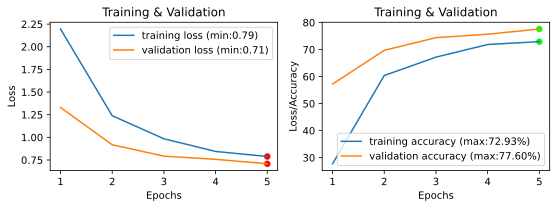

In [ ]:
# plotting loss  curves for resnet 50 v2
plot_loss_curves(resnet_history)

In [42]:
# create EFFICIENT NET B0
efficientnet_model=create_model(model_url=efficientnet_url,num_classes=train_data.num_classes)
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [44]:
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf_keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [45]:
# fitting model 
efficientnet_history  = efficientnet_model.fit(train_data,
                                   epochs=5,
                                   steps_per_epoch=len(train_data),
                                   validation_data=valid_data,
                                   validation_steps=len(valid_data),
                                   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnet_b0")])

Saving TensorBoard log files to : tensorflow_hub/efficientnet_b0/20250312-133301
Epoch 1/5
24/24 [==============================] - 96s 4s/step - loss: 1.9395 - accuracy: 0.3800 - val_loss: 1.4054 - val_accuracy: 0.6796
Epoch 2/5
24/24 [==============================] - 89s 4s/step - loss: 1.2734 - accuracy: 0.6893 - val_loss: 0.9829 - val_accuracy: 0.7748
Epoch 3/5
24/24 [==============================] - 82s 4s/step - loss: 1.0131 - accuracy: 0.7560 - val_loss: 0.8104 - val_accuracy: 0.7980
Epoch 4/5
24/24 [==============================] - 85s 4s/step - loss: 0.8470 - accuracy: 0.7760 - val_loss: 0.6754 - val_accuracy: 0.8324
Epoch 5/5
24/24 [==============================] - 81s 3s/step - loss: 0.7447 - accuracy: 0.8120 - val_loss: 0.6352 - val_accuracy: 0.8404


<Figure size 640x480 with 0 Axes>

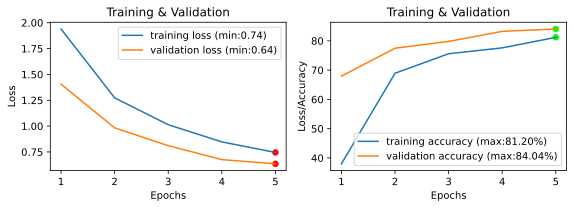

In [46]:
# plotting loss  curves for efficientnet_b0
plot_loss_curves(efficientnet_history)

**5. Visualizing using tensorboard**

* A way to visually explore your ML models performance and internals
* Host, track and share your ML experiments on TensorBoard.dev
* TensorBoard also integrates with websites like weights and biases
* **Note:**: When you upload something to TensorBoard.dev, your experiments are public. 

In [52]:
!tensorboard --logdir=./tensorflow_hub/ --port=6006 

2025-03-12 14:54:01.840210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741771441.858743  296446 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741771441.864252  296446 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 14:54:01.883642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 14:54:04.191107: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL